© Julian Nowak 2022r.

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

Flying planes dataset https://www.kaggle.com/eabdul/flying-vehicles/tasks

In [2]:
! kaggle datasets download -d eabdul/flying-vehicles
! mkdir dataset
! unzip flying-vehicles.zip -d dataset

100%|██████████████████████████████████████| 1.43G/1.43G [01:15<00:00, 31.9MB/s]
100%|██████████████████████████████████████| 1.43G/1.43G [01:15<00:00, 20.4MB/s]
Archive:  flying-vehicles.zip
  inflating: dataset/data/planes/drone/00000000.jpg  
  inflating: dataset/data/planes/drone/00000001.jpg  
  inflating: dataset/data/planes/drone/00000002.jpg  
  inflating: dataset/data/planes/drone/00000003.jpg  
  inflating: dataset/data/planes/drone/00000004.jpg  
  inflating: dataset/data/planes/drone/00000005.jpg  
  inflating: dataset/data/planes/drone/00000006.jpg  
  inflating: dataset/data/planes/drone/00000007.jpg  
  inflating: dataset/data/planes/drone/00000008.jpg  
  inflating: dataset/data/planes/drone/00000009.jpg  
  inflating: dataset/data/planes/drone/00000010.jpg  
  inflating: dataset/data/planes/drone/00000011.jpeg  
  inflating: dataset/data/planes/drone/00000012.jpg  
  inflating: dataset/data/planes/drone/00000013.jpg  
  inflating: dataset/data/planes/drone/00000014.jpg

dataset into training set and validation set

In [2]:
names = ['helicopter', 'passenger-plane', 'rocket',]#'fighter-jet', 'missile', 'rocket', 
os.mkdir('dataset/flying/')
os.mkdir('dataset/flying/training/')
os.mkdir('dataset/flying/testing/')
for plane in names:
    os.mkdir('dataset/flying/training/' + plane + '/')
    os.mkdir('dataset/flying/testing/' + plane + '/')


In [4]:
#splitting data into training and testing folder
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    lista = os.listdir(SOURCE)
    lista = random.sample(lista, len(lista))
    i = 1
    for file in lista:
        sourceName = str(SOURCE  + file)
        if os.path.getsize(sourceName) > 0:
            try:
                if i/len(lista) <= SPLIT_SIZE:
                    copyfile(sourceName, str(TRAINING  + file))
                    #print(i)
                else:
                    copyfile(sourceName, str(TESTING  + file))
                    #print(i)
                i +=1
            except OSError:
                print(str(file) + ' doesnt exist')

split_size = .9 #split size - 90% training, 10% validation
for plane in names: 
    split_data('dataset/data/planes/' + plane + '/', 'dataset/flying/training/' + plane + '/', 'dataset/flying/testing/' + plane + '/', split_size)

.ipynb_checkpoints doesnt exist


In [5]:
#testing size of sub sets (should be 1:10 ratio)
print(len(os.listdir('dataset/flying/training/helicopter/')))
print(len(os.listdir('dataset/flying/testing/helicopter/')))

1249
138


creating keras model

In [6]:
model = tf.keras.models.Sequential([
    #convolutions
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
# Compile Model. 
opt = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

Metal device set to: Apple M1


2022-01-24 19:08:39.334222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-24 19:08:39.334903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


preparing images for analysis

In [7]:
TRAINING_DIR = "dataset/flying/training/"
train_datagen = ImageDataGenerator( #creating more images from the ones we have, to improve learning
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator =  train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150)) 
VALIDATION_DIR = "dataset/flying/testing/"
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 2999 images belonging to 3 classes.
Found 337 images belonging to 3 classes.


training

In [8]:
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, validation_data = validation_generator, epochs=20, steps_per_epoch=128, validation_steps=16, verbose=1)
model.save('model_ml1.h5')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

2022-01-24 19:08:54.795577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-24 19:08:54.796821: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-01-24 19:08:55.079669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.4850

2022-01-24 19:09:22.341742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 31s 237ms/step - loss: 1.1966 - accuracy: 0.4850 - val_loss: 0.9958 - val_accuracy: 0.4781
Epoch 2/20
128/128 [==============================] - 31s 239ms/step - loss: 0.8832 - accuracy: 0.5647 - val_loss: 0.8397 - val_accuracy: 0.5625
Epoch 3/20
128/128 [==============================] - 30s 234ms/step - loss: 0.8152 - accuracy: 0.6081 - val_loss: 0.8059 - val_accuracy: 0.6375
Epoch 4/20
128/128 [==============================] - 30s 233ms/step - loss: 0.7798 - accuracy: 0.6299 - val_loss: 0.7833 - val_accuracy: 0.6156
Epoch 5/20
128/128 [==============================] - 30s 238ms/step - loss: 0.7542 - accuracy: 0.6573 - val_loss: 0.8228 - val_accuracy: 0.6188
Epoch 6/20
128/128 [==============================] - 30s 236ms/step - loss: 0.7467 - accuracy: 0.6721 - val_loss: 0.6919 - val_accuracy: 0.6687
Epoch 7/20
128/128 [==============================] - 30s 234ms/step - loss: 0.7141 - accuracy: 0.6823 - val_loss: 0.7718 - val_accuracy: 0.6

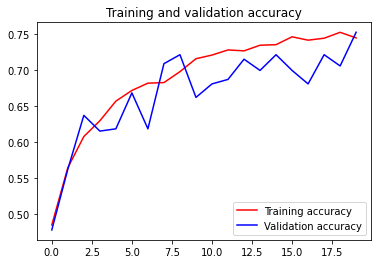

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [10]:
#test for my own photos (also found in google)
import numpy as np
from keras.preprocessing import image

for fn in os.listdir('test_photos/'):
    try:
        # predicting images
        path = 'test_photos/'+fn
        img = image.load_img(path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) 

        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(fn)
        print(classes)
    except OSError:
        print(str(file) + ' not a proper photo')

2022-01-24 19:19:17.948885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


airplane2.jpeg
[[0. 1. 0.]]
helicopter1.jpeg
[[0. 1. 0.]]
airplane3.jpeg
[[0. 1. 0.]]
helicopter6.jpeg
[[0. 1. 0.]]
rakieta1.jpeg
[[0. 1. 0.]]
airplane4.jpeg
[[0. 1. 0.]]
helicopter4.jpeg
[[0. 1. 0.]]
airplane.jpeg
[[0. 1. 0.]]
rakieta3.jpeg
[[0. 1. 0.]]
rakieta2.jpeg
[[0. 1. 0.]]
helicopter5.jpeg
[[0. 1. 0.]]
helicopter2.jpeg
[[1. 0. 0.]]
helicopter3.jpeg
[[1. 0. 0.]]


format: [helicopter, airplane, rocket] 


ready model can be loaded here for testing

In [13]:
new_model = tf.keras.models.load_model('model_ml1.h5')
import numpy as np
from keras.preprocessing import image


for fn in os.listdir('test_photos/'):
    try:
        # predicting images
        path = 'test_photos/'+fn
        img = image.load_img(path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) 

        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(fn)
        print(classes)
    except OSError:
        print(str(file) + ' not a proper photo')

airplane2.jpeg
[[0. 1. 0.]]
helicopter1.jpeg
[[0. 1. 0.]]
airplane3.jpeg
[[0. 1. 0.]]
helicopter6.jpeg
[[0. 1. 0.]]
rakieta1.jpeg
[[0. 1. 0.]]
airplane4.jpeg
[[0. 1. 0.]]
helicopter4.jpeg
[[0. 1. 0.]]
airplane.jpeg
[[0. 1. 0.]]
rakieta3.jpeg
[[0. 1. 0.]]
rakieta2.jpeg
[[0. 1. 0.]]
helicopter5.jpeg
[[0. 1. 0.]]
helicopter2.jpeg
[[1. 0. 0.]]
helicopter3.jpeg
[[1. 0. 0.]]


format: [helicopter, airplane, rocket]